# Optimization Methods: Unconstrained and Constrained Approaches

Optimization plays a fundamental role in various fields of applied mathematics, machine learning, and engineering. Many real-world problems involve finding the minimum of a function, either with or without constraints. This notebook explores several optimization techniques, focusing on both unconstrained and constrained optimization problems.

We begin with unconstrained optimization, where we examine different gradient-based methods:

- **Fixed Step Gradient Descent:** A classical approach that updates the solution iteratively using a fixed step size.
- **Optimal Step Gradient Descent:** An improved method that selects the best possible step size at each iteration to accelerate convergence.
- **Nesterov’s Accelerated Gradient Descent:** A momentum-based method designed to speed up convergence by incorporating previous updates.

Next, we extend our study to constrained optimization. We explore three major approaches:

- **Projected Gradient Descent:** A method that ensures feasibility by projecting the solution onto the constraint set after each update.
- **Exterior Penalty Method:** A technique that approximates constrained optimization by adding a penalty term that discourages constraint violations.
- **Uzawa’s Method:** A dual optimization technique that iteratively updates both the primal variables (solution) and the dual variables (Lagrange multipliers).

In [46]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt

## 1. Problem Setup and Parameter Initialization  

We consider the quadratic function:  

$$ f(x, y) = \frac{1}{2} x^2 + \frac{7}{2} y^2 $$  

The goal is to minimize this function using different optimization algorithms. The Hessian matrix $A$ and gradient vector $b$ are defined as:  

$$ A = \begin{bmatrix} 1 & 0 \\ 0 & 7 \end{bmatrix}, \quad b = 0 $$  

We initialize the optimization with:  

- **Starting point**: $ X_0 = (7, 1.5) $  
- **Fixed step size**: $ \tau = \frac{1}{7} $
- **Convergence threshold**: $ e = 10^{-3} $

These parameters will be used for testing the optimization algorithms.

In [47]:
# Define the matrix A for the quadratic function
A = np.array([[1, 0], 
              [0, 7]])  # A is a 2x2 symmetric matrix

# Define the scalar b
b = 0

# Define the initial starting point X0 for gradient descent
X0 = np.array([7, 1.5])

# Define the learning rate (step size) for gradient descent
taux = 1/7

# Define the convergence threshold (epsilon)
e = 1e-3

## 2. Unconstrained Optimization Methods

In this section, we explore gradient-based optimization techniques for minimizing a quadratic function without constraints.

### 2.1 Gradient Descent With Fixed Step Size

Gradient descent is an iterative optimization algorithm used to minimize differentiable functions. In the fixed step size variant, the step size (learning rate) remains constant throughout the iterations.  

#### Algorithm  
Given a quadratic function of the form:  
$$ f(x) = \frac{1}{2} x^T A x - b^T x $$  
where $ A $ is a positive definite matrix, the gradient descent update rule is:  
$$ X_{k+1} = X_k - \tau \nabla f(X_k) $$  
where:  
- $ \tau $ is a fixed step size,  
- $ \nabla f(X_k) = A X_k - b $ is the gradient of the function. 

#### Convergence and Behavior 
- A fixed step size must be chosen carefully. If it is too large, the method may not converge; if too small, convergence will be slow.    
- The optimal step size for a quadratic function is $ \tau = \frac{2}{\lambda_{\max} + \lambda_{\min}} $, where $ \lambda_{\max} $ and $ \lambda_{\min} $ are the largest and smallest eigenvalues of $ A $, respectively.  

In [3]:
def descente_gradient_pas_fixe_quadratique(A, b, X0, taux=0, e=1e-4):
    """
    Implements gradient descent with a fixed step size for a quadratic function.

    Parameters:
    - A (ndarray): Positive definite matrix defining the quadratic form.
    - b (ndarray): Vector in the quadratic function.
    - X0 (ndarray): Initial guess for the solution.
    - taux (float, optional): Step size for gradient descent (default is the optimal fixed step size).
    - e (float, optional): Convergence tolerance (default = 1e-4).

    Returns:
    - LX (ndarray): History of x-coordinates during optimization.
    - LY (ndarray): History of y-coordinates during optimization.
    - nbIt (int): Number of iterations required for convergence.
    """
    # Compute eigenvalues of A to determine the best step size if not given
    eigenvalues = np.linalg.eigvals(A)
    lambda_min = eigenvalues.min()  # Smallest eigenvalue
    lambda_max = eigenvalues.max()  # Largest eigenvalue
    
    if taux == 0:  # If step size is not provided, use the optimal fixed step
        taux = 2 / (lambda_min + lambda_max)

    # Initialization
    dist = 1  # Distance ||X(n+1) - X(n)||
    Xn = X0
    LX = [X0[0]]  # Store x-values for visualization
    LY = [X0[1]]  # Store y-values for visualization
    nbIt = 0      # Iteration counter

    # Iterative gradient descent
    while dist > e:
        # Compute the next iterate
        Y = Xn - taux * (A @ Xn - b)
        LX.append(Y[0])
        LY.append(Y[1])
        
        # Compute distance between successive iterates
        dist = np.linalg.norm(Y - Xn)
        
        # Update current iterate
        Xn = Y
        nbIt += 1

    return np.array(LX), np.array(LY), nbIt

### 2.2 Gradient Descent with Optimal Step Size 

In contrast to the fixed step size approach, the optimal step size gradient descent dynamically selects the best step size at each iteration to accelerate convergence.  

#### Algorithm  
Given the quadratic function:  
$$ f(x) = \frac{1}{2} x^T A x - b^T x, $$  
the gradient descent update rule remains:  
$$ X_{k+1} = X_k - \tau_k \nabla f(X_k), $$  
but here, the step size $ \tau_k $ is chosen optimally at each iteration to minimize the function along the descent direction.  

The optimal step size for quadratic functions is given by:  
$$ \tau_k = \frac{\nabla f(X_k)^T \nabla f(X_k)}{\nabla f(X_k)^T A \nabla f(X_k)}. $$  

#### Convergence and Behavior 
- This method avoids the sensitivity issues of a fixed step size by dynamically adjusting the learning rate.  
- The trajectory toward the minimum is more direct, reducing oscillations and improving efficiency.  
- Compared to the fixed step approach, this method converges in fewer iterations and follows a more stable path.  

Using the optimal step size provides a significant improvement in convergence speed, making it a preferred choice when the structure of the function is known.


In [48]:
def taux_opt(X):
    """
    Computes the optimal step size for gradient descent based on the given point X.
    The formula used ensures a dynamically adjusted step size for faster convergence.
    """
    return (X[0]**2 + 49*X[1]**2) / (X[0]**2 + 343*X[1]**2)

def descente_gradient_pas_optimal(A, b, X0, e=1e-4):
    """
    Performs gradient descent with an optimal step size for a quadratic function.
    
    Parameters:
    - A: Quadratic matrix defining the function.
    - b: Linear term in the function.
    - X0: Initial point.
    - e: Convergence threshold (default: 1e-4).
    
    Returns:
    - LX: List of x-values during iterations.
    - LY: List of y-values during iterations.
    - nbIt: Number of iterations performed.
    """
    dist = 1  # Distance ||Xn+1 - Xn||
    Xn = X0
    LX = [X0[0]]  # Stores x-coordinates of the path
    LY = [X0[1]]  # Stores y-coordinates of the path
    nbIt = 0  # Iteration counter
    
    while dist > e:
        gradient_f = A @ Xn - b  # Compute gradient
        if np.all(gradient_f == 0):  # Stop if gradient is zero (minimum reached)
            break
        
        taux_n = taux_opt(Xn)  # Compute optimal step size
        Y = Xn - taux_n * gradient_f  # Update step
        
        LX.append(Y[0])
        LY.append(Y[1])
        dist = np.linalg.norm(Y - Xn)  # Compute distance between iterations
        Xn = Y  # Update current point
        nbIt += 1  # Increment iteration count
    
    return np.array(LX), np.array(LY), nbIt

### 2.3 Nesterov's Accelerated Gradient Descent

Nesterov's accelerated gradient descent (NAG) is an optimization algorithm designed to improve convergence speed compared to standard gradient descent. It introduces a momentum term that helps anticipate the next step, reducing oscillations and leading to faster convergence.

#### Algorithm 
Given a quadratic function of the form:
$$ f(x) = \frac{1}{2} x^T A x - b^T x $$
where $ A $ is a symmetric positive definite matrix and $ b $ is a vector, the algorithm iterates as follows:

1. Compute the step size: $ t = \frac{1}{M} $, where $ M $ and $ m $ are the maximum and minimum eigenvalues of $ A $.
2. Define the momentum parameter: 
   $$ \beta = \frac{\sqrt{M} - \sqrt{m}}{\sqrt{M} + \sqrt{m}} $$
3. Perform the extrapolated update:
   $$ Y_k = X_k + \beta (X_k - X_{k-1}) $$
4. Update using gradient information:
   $$ X_{k+1} = X_k - t \nabla f(Y_k) + Y_k $$

#### Convergence and Behavior
- NAG allows for faster convergence by incorporating information from the previous step into the current update.
- It speeds up convergence by reducing oscillations and overshooting, especially in ill-conditioned problems.  
- The method often outperforms standard gradient descent by leveraging past velocity information.  

In [50]:
def descente_gradient_acceleree_Nesterov(A, b, X0, X_1, e):
    """
    Implements Nesterov's Accelerated Gradient Descent for quadratic functions.

    Parameters:
    - A: Quadratic matrix defining the function.
    - b: Linear term in the function.
    - X0: Initial point.
    - X_1: Previous step initialization.
    - e: Convergence threshold.

    Returns:
    - LX: List of x-values during iterations.
    - LY: List of y-values during iterations.
    - nbIt: Number of iterations performed.
    """
    vps = np.linalg.eigvals(A)  # Compute eigenvalues of A
    m = vps.min(axis=0)  # Smallest eigenvalue
    M = vps.max(axis=0)  # Largest eigenvalue
    t = 1 / M  # Step size parameter
    beta = (np.sqrt(M) - np.sqrt(m)) / (np.sqrt(M) + np.sqrt(m))  # Momentum term

    dist = 1  # Distance measure
    Xn = X0
    Xm = X_1
    LX = [X0[0]]  # Stores x-coordinates of the path
    LY = [X0[1]]  # Stores y-coordinates of the path
    nbIt = 0  # Iteration counter

    while dist > e:
        Y = Xn + beta * (Xn - Xm)  # Nesterov's extrapolation step
        Xk = Y - t * (A @ Y - b)  # Gradient update with momentum

        LX.append(Xk[0])
        LY.append(Xk[1])

        dist = np.linalg.norm(Xk - Xn)  # Compute distance between iterations

        Xm = Xn  # Update previous step
        Xn = Xk  # Update current step
        nbIt += 1  # Increment iteration count

    return np.array(LX), np.array(LY), nbIt


In [74]:
def Plot(X, Y, f, forms, labels, title, s):
    """
    Plots the contour lines of a function and overlays optimization paths.
    
    Parameters:
    - `X` (list of arrays): List of x-coordinates from different optimization algorithms.
    - `Y` (list of arrays): List of y-coordinates corresponding to `X`.
    - `f` (function): The function to be visualized in the contour plot.
    - `forms` (list of strings): Line styles for different optimization paths.
    - `labels` (list of strings): Labels for the plotted optimization paths.
    - `title` (string): Title of the plot.
    - `s` (tuple): A point to highlight, typically the optimal solution.
    """
    x1 = np.linspace(-4, 10, 150)  # Range for x-axis
    x2 = np.linspace(-4.5, 4.5, 150)  # Range for y-axis
    X1, X2 = np.meshgrid(x1, x2)  # Create grid for contour plot
    Z = f(X1, X2)  # Compute function values
    
    fig = plt.figure(figsize=(10,7))
    contours = plt.contour(X1, X2, Z, 20)  # Plot contour lines
    plt.clabel(contours, inline=True, fontsize=10)  # Label contours
    plt.title(title, fontsize=15)
    
    # Plot optimization paths
    for x, y, form, label in zip(X, Y, forms, labels):
        plt.plot(x, y)  # Plot path
        plt.plot(x, y, form, label=label)  # Add specific style and label
    
    # Mark optimal point
    plt.plot(s[0], s[1], '*', markersize=10, label='Optimal Point')
    
    plt.xlabel('x', fontsize=11)
    plt.ylabel('y', fontsize=11)
    plt.colorbar()
    plt.legend(loc="upper left")
    plt.show()

### 2.4 Comparison of Gradient Descent Methods  

We now apply three different gradient descent methods to minimize the quadratic function:  

1. **Fixed Step Gradient Descent**: Uses a constant step size.  
2. **Optimal Step Gradient Descent**: Computes the best step size adaptively at each iteration.  
3. **Nesterov's Accelerated Gradient Descent**: Utilizes momentum to improve convergence speed.  

For each method, we record:  

- The number of iterations required to reach convergence.  
- The final estimated minimum $(x, y)$.  
- The optimization path taken.  

Finally, we visualize the optimization trajectories on the function's contour plot to compare their performance.  


Number of iterations for fixed step gradient descent:  46
Minimum found using fixed step gradient descent:  0.005828351250452172 0.0
Number of iterations for optimal step gradient descent:  26
Minimum found using optimal step gradient descent:  0.0015253454537250697 0.00032685974008394355
Number of iterations for Nesterov accelerated gradient descent:  25
Minimum found using Nesterov accelerated gradient descent:  0.001274826642780422 9.598059608932038e-240


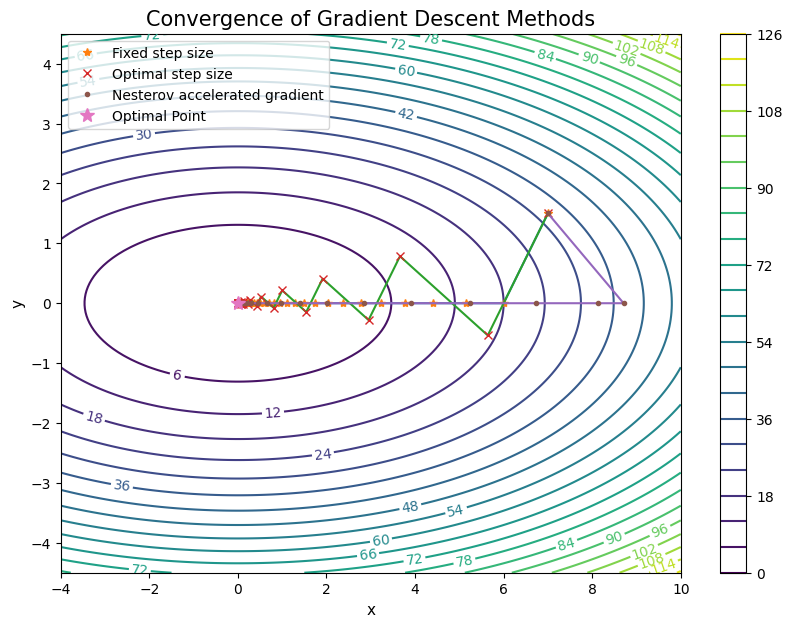

In [52]:
# Perform gradient descent with a fixed step size
X_fix, Y_fix, n_fix = descente_gradient_pas_fixe_quadratique(A, b, X0, taux, e)

# Perform gradient descent with an optimal step size
X_opt, Y_opt, n_opt = descente_gradient_pas_optimal(A, b, X0, e)

# Initial point for Nesterov's accelerated gradient method
X_1 = np.array([0, 0])

# Perform Nesterov's accelerated gradient descent
X_acc_Nes, Y_acc_Nes, n_acc_Nes = descente_gradient_acceleree_Nesterov(A, b, X0, X_1, e)

# Store results for plotting
XX = [X_fix, X_opt, X_acc_Nes]  # X-coordinates of optimization paths
YY = [Y_fix, Y_opt, Y_acc_Nes]  # Y-coordinates of optimization paths

# Define markers and labels for different methods
forms = ['*', 'x', '.']
labels = ['Fixed step size', 'Optimal step size', 'Nesterov accelerated gradient']

# Display results for each method
print("Number of iterations for fixed step gradient descent: ", n_fix)
print("Minimum found using fixed step gradient descent: ", X_fix[-1], Y_fix[-1])

print("Number of iterations for optimal step gradient descent: ", n_opt)
print("Minimum found using optimal step gradient descent: ", X_opt[-1], Y_opt[-1])

print("Number of iterations for Nesterov accelerated gradient descent: ", n_acc_Nes)
print("Minimum found using Nesterov accelerated gradient descent: ", X_acc_Nes[-1], Y_acc_Nes[-1])

# Plot the optimization paths on the function's contour plot
Plot(XX, YY, f, forms, labels, "Convergence of Gradient Descent Methods", np.array([0, 0]))

#### Observations  

1. **Fixed Step Size:**  
   - Converges slowly, requiring **46 iterations**.  
   - The trajectory follows a **zig-zag pattern**, indicating inefficient progress toward the minimum.  
   - The final value is close to zero but **less precise** compared to other methods.  

2. **Optimal Step Size:**  
   - Requires **26 iterations**, demonstrating faster convergence.  
   - The path exhibits **moderate oscillations** before stabilizing near the minimum.  
   - The final point is **very close** to the minimum, confirming its effectiveness.  

3. **Nesterov's Accelerated Gradient:**  
   - Converges in **25 iterations**, making it the fastest method in this comparison.  
   - The trajectory is **directed** toward the minimum with minimal oscillations.
   - The final value is **extremely close** to zero, highlighting its efficiency without excessive instability.
   
 The comparison demonstrates the importance of choosing the right optimization algorithm for your problem. While Nesterov Accelerated Gradient stands out as the best performer, Optimal Step Size remains a strong contender for simpler tasks. Fixed Step Size, while easy to implement, is generally less effective and should be used with caution.

## 3. Constrained Optimization Methods
In this section, we extend the optimization process to constrained problems while using the same quadratic function defined previously. The constraint imposed is:  

$$
g(x, y) = -x + y - 1 = 0
$$

This ensures that the solution remains within a feasible region. We initialize the optimization with:  

- **Starting point**: $ X_0 = (4, 5.5) $  
- **Convergence threshold**: $ e = 10^{-3} $
### 3.1 Projected Gradient Descent
Projected Gradient Descent is an iterative optimization method that ensures constraint satisfaction by projecting each update onto the feasible set.

#### Projection Operator
- Maps a point x to the closest point in the feasible set of all points that satisfy the constraints
- For simple constraints (e.g., $ x \geq 0 $), the projection is straightforward.
- For complex constraints, the projection may require solving an auxiliary optimization problem.

#### Algorithm
the method proceeds as follows:  

1. Compute the gradient of the objective function.
2. Take an unconstrained gradient step.
3. Project the resulting point onto the constraint set to enforce feasibility.

The projection ensures that each iterate remains within the feasible region, making this method particularly effective for constrained convex optimization problems.

In [53]:
def projection(X):
    """
    Projects the point X onto the constraint set defined by y = x + 1.
    
    Parameters:
    - X: A 2D point (numpy array) to be projected.
    
    Returns:
    - The projected point satisfying the constraint.
    """
    return np.array([(X[0] + X[1] - 1) / 2, (X[0] + X[1] + 1) / 2])

def gradient_projete(A, b, X0, e=1e-4): 
    """
    Implements the projected gradient descent algorithm for constrained optimization.
    
    Parameters:
    - A: Quadratic matrix defining the function.
    - b: Linear term in the function.
    - X0: Initial point.
    - e: Convergence threshold (default: 1e-4).
    
    Returns:
    - LX: List of x-values during iterations.
    - LY: List of y-values during iterations.
    - nbIt: Number of iterations performed.
    """
    dist = 1  # Distance measure to track convergence
    Xn = X0  # Current iterate
    LX = [X0[0]]  # Stores x-coordinates of the trajectory
    LY = [X0[1]]  # Stores y-coordinates of the trajectory
    nbIt = 0  # Iteration counter
    
    while dist > e:
        gradient_f = A @ Xn - b  # Compute gradient
        
        # Stop if the gradient is zero (local minimum reached)
        if np.all(gradient_f == 0):
            break
        
        taux_n = taux_opt(Xn)  # Compute optimal step size
        Y = projection(Xn - taux_n * gradient_f)  # Perform projected update
        
        # Store the new point
        LX.append(Y[0])
        LY.append(Y[1])
        
        dist = np.linalg.norm(Y - Xn)  # Compute movement distance
        Xn = Y  # Update current iterate
        nbIt += 1  # Increment iteration counter
    
    return np.array(LX), np.array(LY), nbIt  

### 3.2 Exterior Penalization Method for Constrained Optimization 

The Exterior Penalization Method transforms a constrained optimization problem into a sequence of unconstrained problems by adding a penalty term to the objective function. This penalty term penalizes constraint violations, ensuring that as optimization progresses, the solution remains feasible.

For a constrained optimization problem of the form:  

$$
\min_{x \in \mathbb{R}^n} f(x) \quad \text{subject to } g(x) = 0
$$

we introduce a penalized objective function:

$$
F_m(x) = f(x) + m N(x)
$$

where $ N(x) $ is a penalty function that increases as $ x $ deviates from the constraint $ g(x) = 0 $, and $ m $ is a penalty parameter that grows over iterations.

#### Algorithm  
1. Initialize $ X_0 $ and choose an initial penalty coefficient $ m $.  
2. Solve the unconstrained optimization problem:  
   $$
   \min_{x} F_m(x)
   $$
   using gradient descent or another suitable method.  
3. Increase the penalty coefficient $ m $ to enforce constraint satisfaction more strictly.  
4. Repeat until convergence.

#### Convergence and Behavior
- As $ m \to \infty $, the solution of the penalized problem converges to the solution of the original constrained problem.  
- The trajectory initially moves toward the unconstrained minimum, then adjusts to satisfy the constraint as $ m $ increases.  
- Large values of $ m $ can lead to numerical instability, requiring a gradual increase.


In [17]:
def penalty(X):
    """
    Computes the penalty function value.
    
    Parameters:
    - X: A 2D point (numpy array).
    
    Returns:
    - Squared constraint violation, ||g(X)||².
    """
    return g(X[0], X[1])**2  # N(X) = ||g(x)||²

def exterior_penalization(X0, e):
    """
    Implements the exterior penalization method for constrained optimization.
    
    Parameters:
    - X0: Initial point (numpy array).
    - e: Convergence threshold.
    
    Returns:
    - LX: List of x-values during iterations.
    - LY: List of y-values during iterations.
    - num_iterations: Total number of iterations.
    """
    k = 1  # Iteration counter
    m = 1  # Penalty coefficient
    dist = 1  # Convergence criterion
    LX = [X0[0]]  # Stores x-coordinates
    LY = [X0[1]]  # Stores y-coordinates
    
    while dist > e:
        # Construct the quadratic approximation matrix
        A = np.array([[1 + 2*m, -2*m], [-2*m, 7 + 2*m]])
        b = np.array([-2*m, 2*m])  # Linear term (c = m)
        
        # Solve using fixed-step quadratic gradient descent
        X, Y, n = descente_gradient_pas_fixe_quadratique(A, b, X0, taux=0, e=1e-3)
        
        # Get the last computed point
        Xk = np.array([X[-1], Y[-1]])  
        
        # Store trajectory
        LX.append(Xk[0])
        LY.append(Xk[1])
        
        # Compute distance ||X_k - X_{k-1}||
        dist = np.linalg.norm(Xk - X0)
        
        # Update the initial point for the next iteration
        X0 = Xk
        m *= 100  # Increase penalty coefficient
        k += 1  # Increment iteration counter
    
    return np.array(LX), np.array(LY), k - 1  # Return results

### 3.3 Uzawa's Method for Constrained Optimization  

Uzawa's Method is an iterative approach for solving constrained optimization problems using dual variables (Lagrange multipliers). It transforms the problem into an augmented gradient descent process, where both the primal variable $ x $ and the Lagrange multiplier $ \lambda $ are updated iteratively.

For a constrained optimization problem:

$$
\min_{x \in \mathbb{R}^n} f(x) \quad \text{subject to } g(x) = 0
$$

Uzawa's method updates both $ x $ and $ \lambda $ iteratively:

$$
X_{k+1} = X_k - \alpha_k \nabla f(X_k, \lambda_k)
$$

$$
\lambda_{k+1} = \lambda_k + t g(X_k)
$$

where $ t $ is a step size parameter controlling the update of the Lagrange multiplier.

#### Algorithm  
1. Initialize $ X_0 $ and $ \lambda_0 $.  
2. Solve the primal problem using gradient descent:  
   $$
   X_{k+1} = X_k - \alpha_k \nabla f(X_k, \lambda_k)
   $$
3. Update the Lagrange multiplier:  
   $$
   \lambda_{k+1} = \lambda_k + t g(X_k)
   $$
4. Repeat until convergence.

#### Convergence and Behavior  
- The method iteratively adjusts $ X $ toward the constrained minimum while refining $ \lambda $ to enforce feasibility.       
- Proper tuning of $ t  is necessary to balance stability and efficiency.


In [19]:
def uzawa(X0, l0, t, e):
    """
    Implements the Uzawa algorithm for solving constrained optimization problems.
    
    Parameters:
    X0 (numpy array): Initial point [x0, y0].
    l0 (float): Initial value of the Lagrange multiplier.
    t (float): Step size for updating the Lagrange multiplier.
    e (float): Convergence threshold.
    
    Returns:
    numpy arrays: Arrays of x and y values during iterations.
    int: Number of iterations taken for convergence.
    """
    
    # Initialize variables
    dist = 1  # Distance between successive points
    LX = [X0[0]]  # Store x-values for visualization
    LY = [X0[1]]  # Store y-values for visualization
    l = l0  # Initialize Lagrange multiplier
    Xn = X0  # Current point
    nbIt = 0  # Iteration counter

    while dist > e:
        # Define matrix A and vector b for quadratic optimization step
        A = np.array([[1, 0], [0, 7]])
        b = np.array([l, -l])  # Constraint influence (c = -l)

        # Perform fixed-step gradient descent for quadratic function
        X, Y, n = descente_gradient_pas_fixe_quadratique(A, b, Xn, taux=0, e=1e-3)

        # Update Lagrange multiplier using Uzawa's rule
        l = l + t * g(X[-1], Y[-1])

        # Store new point and compute distance from the previous one
        Xk = np.array([X[-1], Y[-1]])
        LX.append(Xk[0])
        LY.append(Xk[1])
        dist = np.linalg.norm(Xk - Xn)  # ||X_k - X_{k-1}||

        # Update current point
        Xn = Xk
        nbIt += 1

    return np.array(LX), np.array(LY), nbIt

Number of iterations taken by the gradient descent method with optimal step size and projection: 9
The found minimum is: -0.874999999483721 0.12500000051627902
Number of iterations taken by the penalization method: 4
The minimum found is: -0.8743864214262153 0.1249495429852941
Number of iterations taken by the Uzawa method: 4
Minimum found: -0.8737425747755898 0.12470662746975542


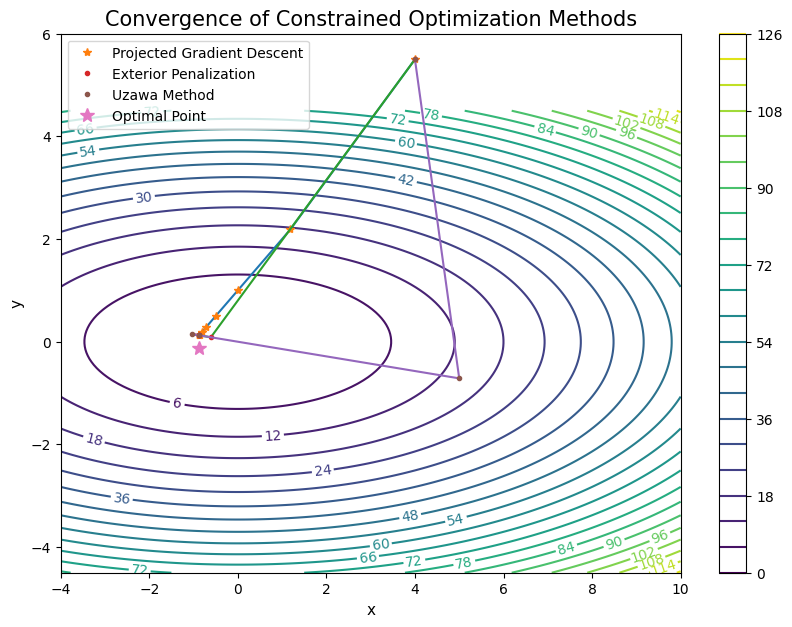

In [73]:
# Define initial point
X0 = np.array([4, 5.5])

# Run the projected gradient descent method
X_pr, Y_pr, n_pr = gradient_projete(A, b, X0, e)

# Perform exterior penalization method
X_pen, Y_pen, n_pen = exterior_penalization(X0, e)

# Initialize parameters for Uzawa's algorithm
l0 = 5        # Initial Lagrange multiplier
t = 0.9     # Step size for updating the multiplier
e = 1e-3      # Convergence threshold

# Run Uzawa's algorithm
X_uz, Y_uz, n_uz = uzawa(X0, l0, t, e)

# Store results for visualization
XX = [X_pr, X_pen, X_uz]
YY = [Y_pr, Y_pen, Y_uz]
forms = ['*', '.', '.']
labels = ['Projected Gradient Descent', 'Exterior Penalization', 'Uzawa Method']

# Print results
print("Number of iterations taken by the gradient descent method with optimal step size and projection:", n_pr)
print("The found minimum is:", X_pr[-1], Y_pr[-1])

print("Number of iterations taken by the penalization method:", n_pen)
print("The minimum found is:", X_pen[-1], Y_pen[-1])

print("Number of iterations taken by the Uzawa method:", n_uz)
print("Minimum found:", X_uz[-1], Y_uz[-1])

# Plot all methods in a single figure
Plot(XX, YY, f, forms, labels, 
     "Convergence of Constrained Optimization Methods",
     np.array([-7/8, -1/8]))

### 3.4 Comparison of Constrained Optimization Methods

1. Projected Gradient Descent:
   - Takes **9 iterations**, the highest among the methods.
   - The final point is is very close to the expected minimum.
   - The trajectory follows a **steepest descent approach** with projections ensuring feasibility at each step.
   - It shows a **smooth and direct convergence** towards the optimal point.

2. Penalization Method:
   - Takes **4 iterations**, much fewer than the projected gradient descent.
   - The final point is slightly less accurate than the projected gradient descent.
   - The method **moves freely at first and then adjusts** based on the penalty term.
   - The trajectory suggests a **fast convergence**, but some deviation from the constraint.
   
3. Uzawa Method:
   - Also takes **4 iterations**, like the penalization method.
   - The final point is slightly further from the optimal compared to penalization.
   - The trajectory exhibits **zig-zag behavior**, suggesting it corrects feasibility and optimality iteratively.
   - This behavior is expected due to **alternating primal and dual updates**.
   
All three constrained optimization methods successfully converge to a similar solution. The Penalization and Uzawa methods converge in fewer iterations, while Projected Gradient Descent requires more steps but maintains feasibility at each iteration. The choice of method depends on the balance between efficiency and constraint satisfaction.